# TDA

There are 4 models:
    - Isolation Forest + KMeans
    - Isolation Forest + AffinityPropagation
    - PCA + KMeans
    - PCA + AffinityPropagation
    
For every model there is .pkl file with results of the model and .html vizualisation.

In [163]:
import re
import os
import time
import pickle
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.sparse
from tqdm import tqdm, tqdm_notebook
from collections import defaultdict, OrderedDict
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix, coo_matrix, csc_matrix

### PUT YOUR PATH HERE (mine default is home/username/notebooks)
path_to_data = '../../shared_files/'

%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

from datetime import datetime
import warnings

# some stuff for pickling
import pickle

def pickle_table(table, filename):
    with open(filename, 'wb') as output_file:
        pickle.dump(table, output_file)
        
def unpickle_table(filename):
    with open(filename, 'rb') as input_file:
        return pickle.load(input_file)
    
# to see all columns in df
pd.set_option('display.large_repr', 'truncate')
pd.set_option('display.max_columns', 0)

from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation

# Kepler Mapper
import kmapper as km

#it's better to use CustomMapper from custom_mapper.py to make memory usage more effective
#(it removes forced index column adding to original data)
import custom_mapper

import IPython

In [156]:
def display(path_html="mapper_visualization_output.html"):
    """ Displays a html file inside a Jupyter Notebook output cell.
    
    Parameters
    ----------
    path_html : str
        Path to html. Use file name for file inside current working 
        directory. Use `file://` browser url-format for path to local file.
        Use `https://` urls for externally hosted resources.

    Notes
    -----
    Thanks to https://github.com/smartinsightsfromdata for the issue:
    https://github.com/MLWave/kepler-mapper/issues/10

    """

    iframe = '<iframe src=' + path_html \
            + ' width=100%% height=800 frameBorder="0"></iframe>'
    IPython.core.display.display(IPython.core.display.HTML(iframe))

In [131]:
# make fonts size normal

from matplotlib.font_manager import FontProperties
import matplotlib

import matplotlib.pyplot as plt

SMALL_SIZE = 35
MEDIUM_SIZE = 50
BIGGER_SIZE = 70

def set_fonts(small_size=SMALL_SIZE, medium_size=MEDIUM_SIZE, bigger_size=BIGGER_SIZE):
    plt.rc('font', size=medium_size)          # controls default text sizes
    plt.rc('axes', titlesize=medium_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=medium_size)    # legend fontsize
    plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title
    
set_fonts()

In [97]:
DATA_PATH = "/home/yanina/TDA/data/off_ops_sample.pkl"
MAPPER_HTML_PATH = "/home/yanina/TDA/graphs/"

cols_to_drop = [
    "P_OFFLINEOPERATIONID",
    "P_DOCCATEGORY",
    "P_EKNPCODE",
    "P_CURRENCYCODE",
     "label",
    "isof",
    "P_SUSPICIOUSTYPECODE",
    "P_CRITERIAFIRST",
    "P_CRITERIASECOND",
    "P_SUSPIC_KIND"
]

### PCA

First we need to prepare linses. ISOF score (first linse) is already in the dataset, PCA (second linse) is prepared here. We use a sample of 82196 operations

In [123]:
raw_data = pickle.load(open(DATA_PATH, "rb"))

In [125]:
targets = raw_data['label']
isof_scores = raw_data['isof']
raw_data.drop(cols_to_drop, axis=1, inplace=True)

In [126]:
raw_data.shape

(82196, 10)

In [127]:
raw_data.head()

,sum:source:out,count:source:out,sum:source:in,count:source:in,sum:target:out,count:target:out,sum:target:in,count:target:in,operation_id,P_BASEAMOUNT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,528657550,151075.01
100,1000.0,1.0,0.0,0.0,15000000.0,-15000.0,15000000.0,-15000.0,528659396,1000.00
200,0.0,0.0,0.0,0.0,15000000.0,-15000.0,15000000.0,-15000.0,528659344,10000.00
300,0.0,0.0,0.0,0.0,15000000.0,-15000.0,15000000.0,-15000.0,528660293,8000.00
400,15000000.0,-15000.0,15000000.0,-15000.0,0.0,0.0,8311.0,1.0,528657934,100000.00


Data scaling before dimension reduction:

In [128]:
from sklearn.preprocessing import scale

data = scale(raw_data)

/home/yanina/anaconda3/envs/research_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [135]:
from sklearn.decomposition import PCA

# n_comp = 2
# svd = decomposition.TruncatedSVD(n_components=n_comp, algorithm='arpack')
# svd.fit(data)
# print(svd.explained_variance_ratio_.sum())

pca = PCA(n_components=2, svd_solver='arpack')

X_embedded_2d = pca.fit_transform(data)

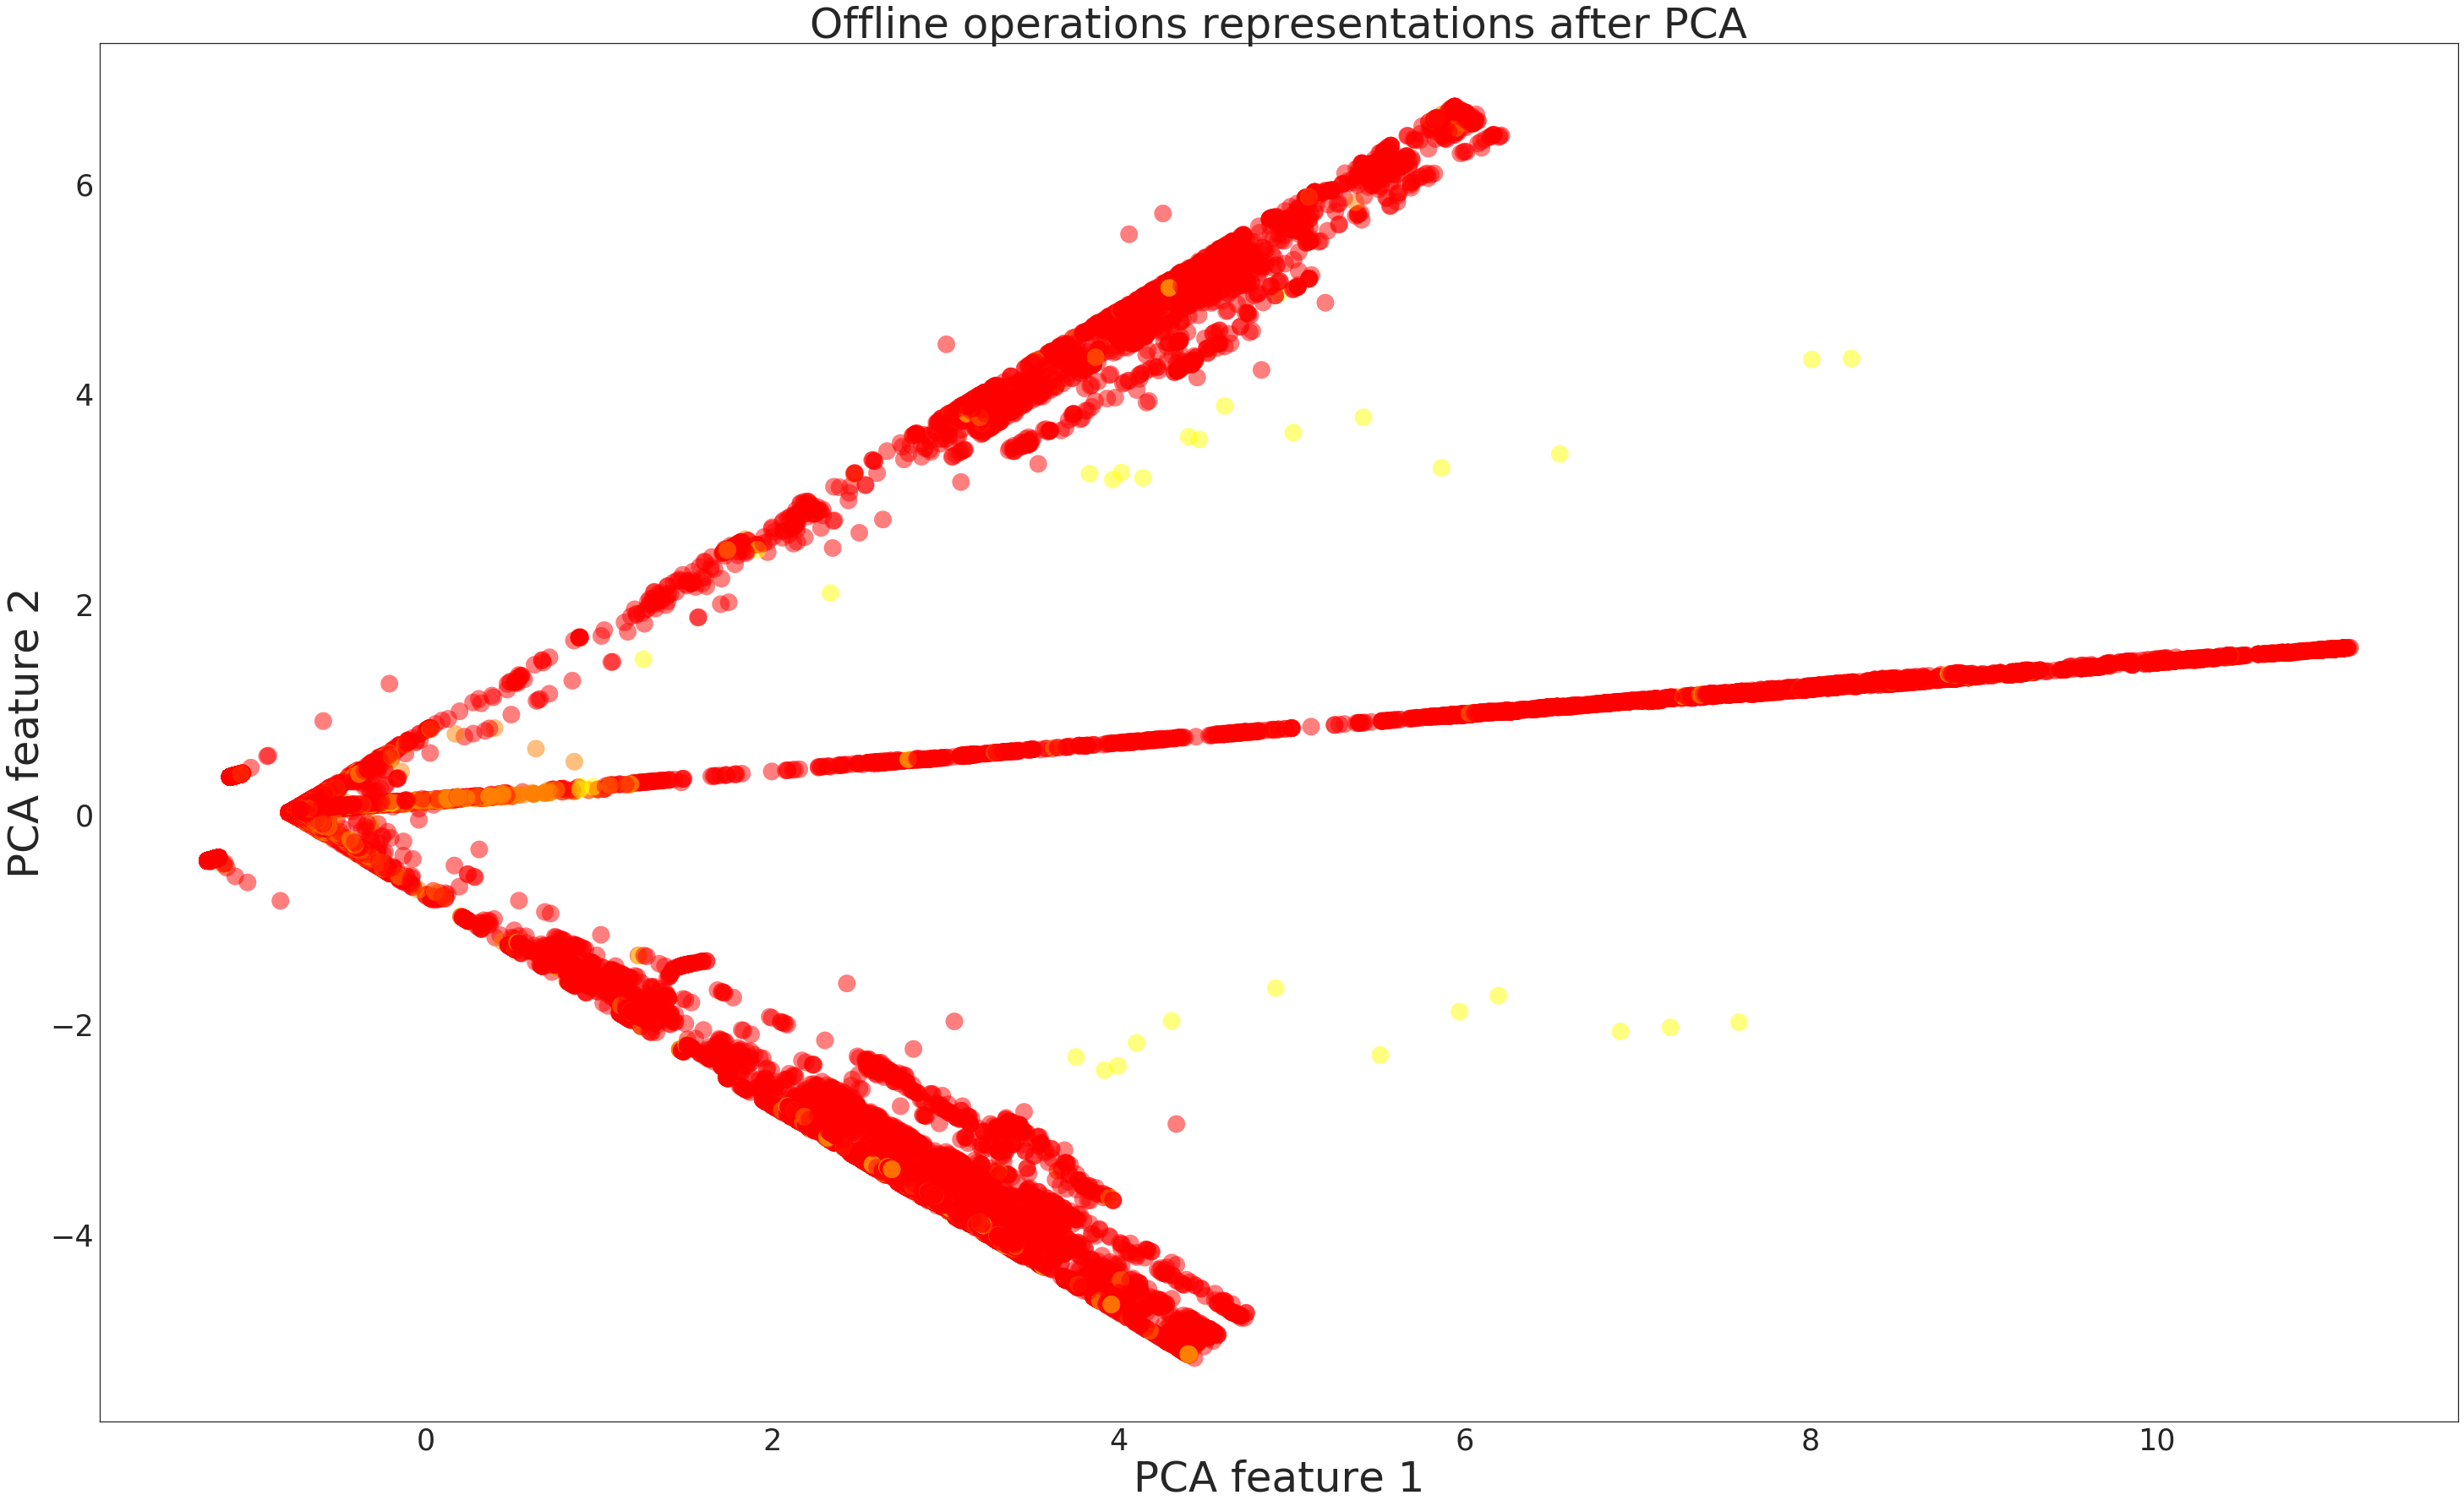

In [136]:
# fraud - red
# normal - yellow

plt.figure(figsize=(50, 30))
plt.title('Offline operations representations after PCA')
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.scatter(X_embedded_2d[:, 0], X_embedded_2d[:, 1], c=targets, alpha=0.5, cmap='autumn', s=420)



In [137]:
pca = PCA(n_components=3, svd_solver='arpack')

X_embedded_3d = pca.fit_transform(data)

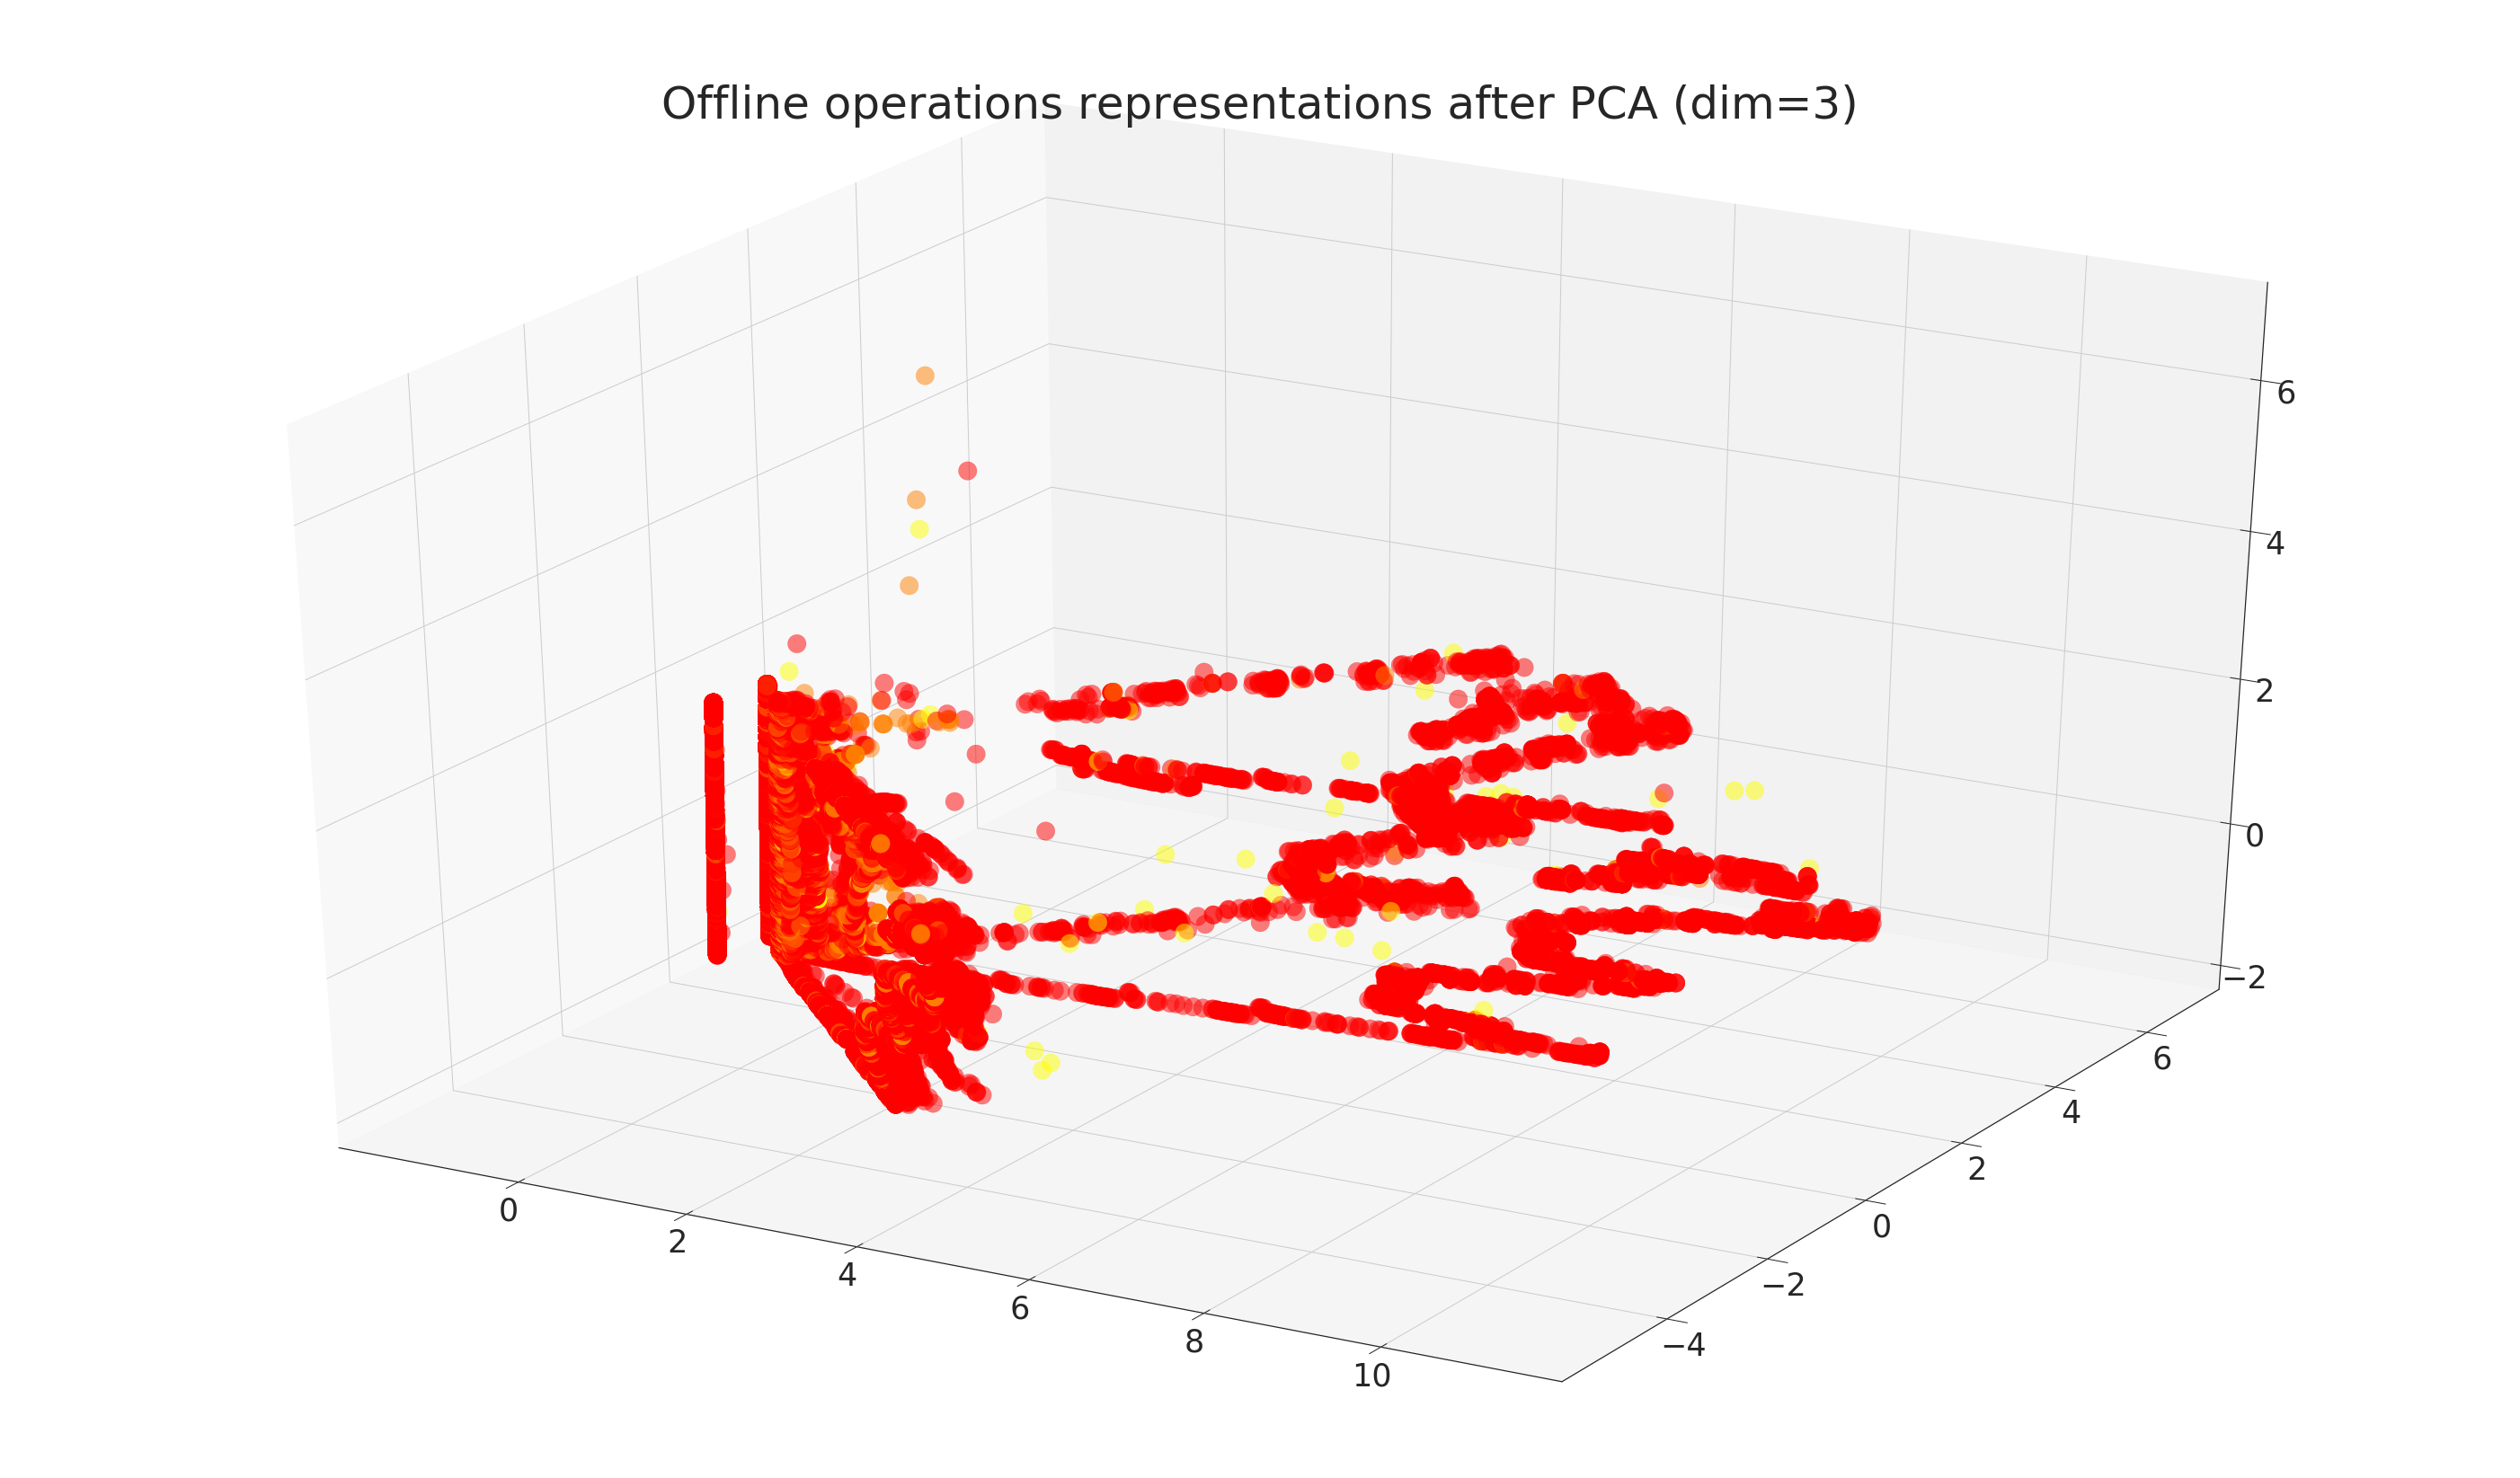

In [138]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(50,30))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_embedded_3d[:, 0], X_embedded_3d[:, 1], X_embedded_3d[:, 2], c=targets, alpha=0.5, cmap='autumn', s=420)

ax.set_title('Offline operations representations after PCA (dim=3)')

plt.show()

### PCA + KMeans

This class helps to estimate n_clusters based on a number of observations:

In [164]:
class MetaKMeans(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin, sklearn.base.TransformerMixin):
    def __init__(self,
                 init='k-means++',
                 n_init=10,
                 max_iter=300,
                 tol=0.0001,
                 precompute_distances='auto',
                 verbose=0,
                 random_state=None,
                 copy_x=True,
                 n_jobs=1,
                 algorithm='auto'):
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.precompute_distances = precompute_distances
        self.verbose = verbose
        self.random_state = random_state
        self.copy_x = copy_x
        self.n_jobs = n_jobs
        self.algorithm = algorithm
        self._temp_clusterer = None
    
    def get_params(self, deep=True):
        params = {
            'init': self.init,
            'n_init': self.n_init,
            'max_iter': self.max_iter,
            'tol': self.tol,
            'precompute_distances': self.precompute_distances,
            'verbose': self.verbose,
            'random_state': self.random_state,
            'copy_x': self.copy_x,
            'n_jobs': self.n_jobs,
            'algorithm': self.algorithm
        }
        return params
    
    def _estimate_n_clusters(self, n):
        return max(1, int(np.log1p(n)) // 2)

    def fit(self, X, y=None):
        n_clusters = self._estimate_n_clusters(len(X))
        self._temp_clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, **self.get_params())
        self._temp_clusterer.fit(X, y)
        self.labels_ = self._temp_clusterer.labels_.copy()

    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.labels_

In [165]:
import kmapper as km

mapper = km.KeplerMapper(verbose=2)
graph = mapper.map(X_embedded_2d, data, clusterer=MetaKMeans(n_jobs=16), nr_cubes=10, overlap_perc=0.1)

Mapping on data shaped (82196, 10) using lens shaped (82196, 2)

Minimal points in hypercube before clustering: 1
Creating 100 hypercubes.
There are 0 points in cube_0 / 100
Cube_0 is empty.

There are 0 points in cube_1 / 100
Cube_1 is empty.

There are 0 points in cube_2 / 100
Cube_2 is empty.

There are 11219 points in cube_3 / 100
Found 4 clusters in cube_3

There are 55246 points in cube_4 / 100
Found 5 clusters in cube_4

There are 18 points in cube_5 / 100
Found 1 clusters in cube_5

There are 0 points in cube_6 / 100
Cube_6 is empty.

There are 0 points in cube_7 / 100
Cube_7 is empty.

There are 0 points in cube_8 / 100
Cube_8 is empty.

There are 0 points in cube_9 / 100
Cube_9 is empty.

There are 0 points in cube_10 / 100
Cube_10 is empty.

There are 0 points in cube_11 / 100
Cube_11 is empty.

There are 416 points in cube_12 / 100
Found 3 clusters in cube_12

There are 478 points in cube_13 / 100
Found 3 clusters in cube_13

There are 534 points in cube_14 / 100
Found 3 cl

In [166]:
html = mapper.visualize(
    graph, 
    inverse_X=X_embedded_2d,
    color_function=targets,
    path_html= MAPPER_HTML_PATH + "PCA_KMeans.html",
    title="PCA(n_components=2) and KMeans for 82196 samples"
)

/home/yanina/anaconda3/envs/research_env/lib/python3.6/site-packages/kmapper/visuals.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  color_function = color_function.reshape(-1, 1)


Wrote visualization to: /home/yanina/TDA/graphs/PCA_KMeans.html


In [167]:
display("graphs/PCA_KMeans.html")

Now let's try 3d PCA as a linse:

In [168]:
mapper = km.KeplerMapper(verbose=2)
graph_pca_3d = mapper.map(X_embedded_3d, data, clusterer=MetaKMeans(n_jobs=16), nr_cubes=5, overlap_perc=0.1)

html = mapper.visualize(
    graph_pca_3d, 
    inverse_X=X_embedded_3d,
    color_function=targets,
    path_html=MAPPER_HTML_PATH + "PCA_KMeans_3d.html",
    title="PCA(n_components=3) and KMeans for 82196 samples"
)

Mapping on data shaped (82196, 10) using lens shaped (82196, 3)

Minimal points in hypercube before clustering: 1
Creating 125 hypercubes.
There are 0 points in cube_0 / 125
Cube_0 is empty.

There are 0 points in cube_1 / 125
Cube_1 is empty.

There are 0 points in cube_2 / 125
Cube_2 is empty.

There are 0 points in cube_3 / 125
Cube_3 is empty.

There are 0 points in cube_4 / 125
Cube_4 is empty.

There are 6494 points in cube_5 / 125
Found 4 clusters in cube_5

There are 5546 points in cube_6 / 125
Found 4 clusters in cube_6

There are 939 points in cube_7 / 125
Found 3 clusters in cube_7

There are 0 points in cube_8 / 125
Cube_8 is empty.

There are 0 points in cube_9 / 125
Cube_9 is empty.

There are 30098 points in cube_10 / 125
Found 5 clusters in cube_10

There are 26134 points in cube_11 / 125
Found 5 clusters in cube_11

There are 3993 points in cube_12 / 125
Found 4 clusters in cube_12

There are 3 points in cube_13 / 125
Found 1 clusters in cube_13

There are 1 points in 

/home/yanina/anaconda3/envs/research_env/lib/python3.6/site-packages/kmapper/visuals.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  color_function = color_function.reshape(-1, 1)


Wrote visualization to: /home/yanina/TDA/graphs/PCA_KMeans_3d.html


In [169]:
display("graphs/PCA_KMeans_3d.html")

### PCA + Affinity Propagation

In [ ]:
# eats too much memory

# mapper = CustomMapper(verbose=2)
# graph_aff_prop = mapper.map(X_embedded_2d, data, clusterer=AffinityPropagation(max_iter=10, convergence_iter=5), nr_cubes=5, overlap_perc=0.1)

It took too much memory, so I stopped it

### Isolation Forest + KMeans

In [ ]:
isof_scores = data['isof']

In [140]:
raw_data.head()

,sum:source:out,count:source:out,sum:source:in,count:source:in,sum:target:out,count:target:out,sum:target:in,count:target:in,operation_id,P_BASEAMOUNT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,528657550,151075.01
100,1000.0,1.0,0.0,0.0,15000000.0,-15000.0,15000000.0,-15000.0,528659396,1000.00
200,0.0,0.0,0.0,0.0,15000000.0,-15000.0,15000000.0,-15000.0,528659344,10000.00
300,0.0,0.0,0.0,0.0,15000000.0,-15000.0,15000000.0,-15000.0,528660293,8000.00
400,15000000.0,-15000.0,15000000.0,-15000.0,0.0,0.0,8311.0,1.0,528657934,100000.00


In [173]:
mapper = km.KeplerMapper(verbose=2)
graph_isof_1 = mapper.map(isof_scores, raw_data.values, clusterer=MetaKMeans(n_jobs=16), nr_cubes=100, overlap_perc=0.1)

html = mapper.visualize(
    graph_isof_1, 
    color_function=targets,
    path_html=MAPPER_HTML_PATH + "ISOF_KMeans.html",
    title="ISOF and KMeans for 82196 samples (100 cubes)"
)

Mapping on data shaped (82196, 10) using lens shaped (82196,)

Minimal points in hypercube before clustering: 1
Creating 100 hypercubes.
There are 1 points in cube_0 / 100
Found 1 clusters in cube_0

There are 1 points in cube_1 / 100
Found 1 clusters in cube_1

There are 1 points in cube_2 / 100
Found 1 clusters in cube_2

There are 0 points in cube_3 / 100
Cube_3 is empty.

There are 0 points in cube_4 / 100
Cube_4 is empty.

There are 0 points in cube_5 / 100
Cube_5 is empty.

There are 0 points in cube_6 / 100
Cube_6 is empty.

There are 2 points in cube_7 / 100
Found 1 clusters in cube_7

There are 5 points in cube_8 / 100
Found 1 clusters in cube_8

There are 12 points in cube_9 / 100
Found 1 clusters in cube_9

There are 10 points in cube_10 / 100
Found 1 clusters in cube_10

There are 13 points in cube_11 / 100
Found 1 clusters in cube_11

There are 20 points in cube_12 / 100
Found 1 clusters in cube_12

There are 20 points in cube_13 / 100
Found 1 clusters in cube_13

There ar

/home/yanina/anaconda3/envs/research_env/lib/python3.6/site-packages/kmapper/visuals.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  color_function = color_function.reshape(-1, 1)


In [174]:
display("graphs/ISOF_KMeans.html")

In [155]:
mapper = km.KeplerMapper(verbose=2)
graph_isof_3 = mapper.map(isof_scores, raw_data.values, clusterer=KMeans(n_clusters=5, n_jobs=16), nr_cubes=100, overlap_perc=0.1)

html = mapper.visualize(
    graph_isof_3, 
    color_function=targets,
    path_html=MAPPER_HTML_PATH + "ISOF_KMeans_5clusters.html",
    title="ISOF and KMeans(n_clusters=5) for 82196 samples (100 cubes)"
)

Mapping on data shaped (82196, 10) using lens shaped (82196,)

Minimal points in hypercube before clustering: 5
Creating 100 hypercubes.
There are 1 points in cube_0 / 100
Cube_0 is empty.

There are 1 points in cube_1 / 100
Cube_1 is empty.

There are 1 points in cube_2 / 100
Cube_2 is empty.

There are 0 points in cube_3 / 100
Cube_3 is empty.

There are 0 points in cube_4 / 100
Cube_4 is empty.

There are 0 points in cube_5 / 100
Cube_5 is empty.

There are 0 points in cube_6 / 100
Cube_6 is empty.

There are 2 points in cube_7 / 100
Cube_7 is empty.

There are 5 points in cube_8 / 100
Found 5 clusters in cube_8

There are 12 points in cube_9 / 100
Found 5 clusters in cube_9

There are 10 points in cube_10 / 100
Found 5 clusters in cube_10

There are 13 points in cube_11 / 100
Found 5 clusters in cube_11

There are 20 points in cube_12 / 100
Found 5 clusters in cube_12

There are 20 points in cube_13 / 100
Found 5 clusters in cube_13

There are 38 points in cube_14 / 100
Found 5 clu

/home/yanina/anaconda3/envs/research_env/lib/python3.6/site-packages/kmapper/visuals.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  color_function = color_function.reshape(-1, 1)


In [175]:
display("graphs/ISOF_KMeans_5clusters.html")

### Isolation Forest + Affinity Propagation

Works veeeery long time

In [60]:
mapper = CustomMapper(verbose=2)
graph_isof_affprop = mapper.map(isof_scores, raw_data.values, clusterer=AffinityPropagation(max_iter=10), nr_cubes=10, overlap_perc=0.1)

html = mapper.visualize(
    graph_isof_affprop,                     
    color_function=targets,                     
    path_html=MAPPER_HTML_PATH + "ISOF_AffProp.html",                    
    title="ISOF and AffProp for 82196 samples (10 cubes)")

/home/yanina/anaconda3/envs/research_env/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: Explicitly passing in nr_cubes and overlap_perc will be deprecated in future releases. Please supply Cover object.


Mapping on data shaped (82196, 10) using lens shaped (82196,)

Minimal points in hypercube before clustering: 1
Creating 10 hypercubes.
There are 31 points in cube_0 / 10
Found 3 clusters in cube_0

There are 288 points in cube_1 / 10
Found 113 clusters in cube_1

There are 517 points in cube_2 / 10
Found 505 clusters in cube_2

There are 1388 points in cube_3 / 10
Found 518 clusters in cube_3

There are 4193 points in cube_4 / 10
Found 1449 clusters in cube_4

There are 5300 points in cube_5 / 10
Found 1463 clusters in cube_5

There are 8953 points in cube_6 / 10
Found 5680 clusters in cube_6

There are 14378 points in cube_7 / 10
Found 12452 clusters in cube_7

There are 8790 points in cube_8 / 10
Found 6662 clusters in cube_8

There are 43004 points in cube_9 / 10
Found 33106 clusters in cube_9


Created 3948 edges and 61951 nodes in 0:59:59.271611.


/home/yanina/anaconda3/envs/research_env/lib/python3.6/site-packages/kmapper/visuals.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  color_function = color_function.reshape(-1, 1)


Wrote visualization to: graphs/ISOF_AffProp.html
